image size:  (1920, 1080)


Text(0.5, 1.0, 'original cover image')

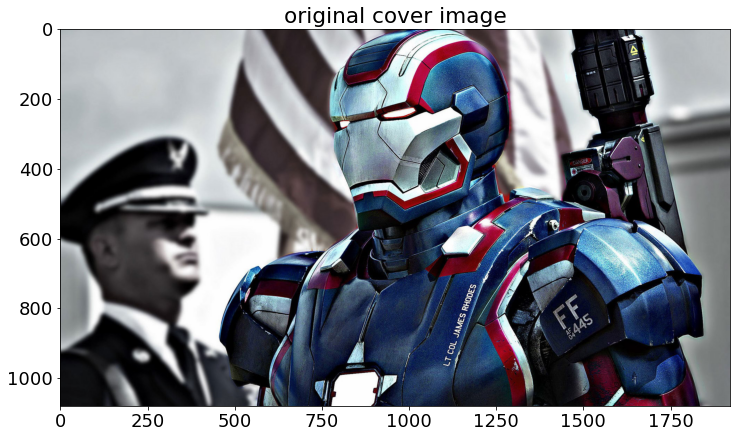

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [12,8]
plt.rcParams.update({'font.size':18})

# creating a object 
# PATH = "ImageSources\\jfif\\darth_vader.jfif"
# PATH = "ImageSources\\jfif\\the_rock.jfif"
# PATH = "ImageSources\\jfif\\obi-wan_kenobi.jfif"
PATH = "ImageSources\\jpg\\iron_patriot.jpg"
# PATH = "ImageSources\\png\\r2d2.png"
image = Image.open(PATH)
image.load()
Rot, Grün, Blau= image.split() #split image into its RGB channels

print("image size: ",image.size)

plt.figure()
plt.imshow(image)
plt.title("original cover image")

Functions for encoding and decoding

In [4]:
string="""It's about drive, it's about power
We stay hungry, we devour 💪😄
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana
"""


""" string version """
def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits,2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'

    
""" int version """
def text_to_bits_int(text, gain):
    string_bits = text_to_bits(text)
    # convert each char to int
    message_bits = [int(i)*gain for i in string_bits]
    # get length of bitstream as bytes (overflow error if too large)
    formated = bin(len(message_bits))[2:]
    while len(formated) < 16:
        formated = '0' + formated
    message_len = [int(j)*gain for j in formated]
    # append length onto the first 2 bytes of the message
    message_bits = message_len + message_bits
    return message_bits


def text_from_bits_int(bits):
    # convert each element to string
    message_len_bits = bits[:16]
    message_len = ""
    for bit in message_len_bits:
        message_len = message_len + str(bit)
    message_len = int(message_len, 2)
    string_bits = [str(i) for i in bits[16:message_len+16]]
    string_concat = ""
    # concatenate each element to one string
    for string in string_bits:
        string_concat += string
    string_decode = text_from_bits(string_concat)
    return string_decode, message_len

# normalize a channel by its max and min values
def convert(img, target_type_min, target_type_max, target_type):
    imin = img.min()
    imax = img.max()

    a = (target_type_max - target_type_min) / (imax - imin)
    b = target_type_max - a * imax
    new_img = (a * img + b).astype(target_type)
    return new_img

# convert inverse transformed message to parsable binary message
def message2bin(message, threshold):
    digital = np.zeros(len(message)).astype('uint8')
    for ix, m in enumerate(message):
        if m > threshold:
            digital[ix] = 1
        else:
            digital[ix] = 0
    return digital

Embed hidden message inside the absolute spektrum of the Fourier-Transform and reverse the process to save the resulting image as .png

MASK:

bin_encoded: [0, 0, 0, 50000, 0, 0, 0, 50000, 0, 50000, 50000, 50000, 0, 0, 0, 0, 0, 50000, 0, 0]
cut:  0.0677062464065845
message length: 4480
confirm: 4810.0


C:\Users\maxik\AppData\Local\Temp/ipykernel_38432/875469751.py:31: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(20*np.log10(cover_r_fft_masked))


Text(0.5, 1.0, 'Red channel in frequency domain, filtered with mask (log)')

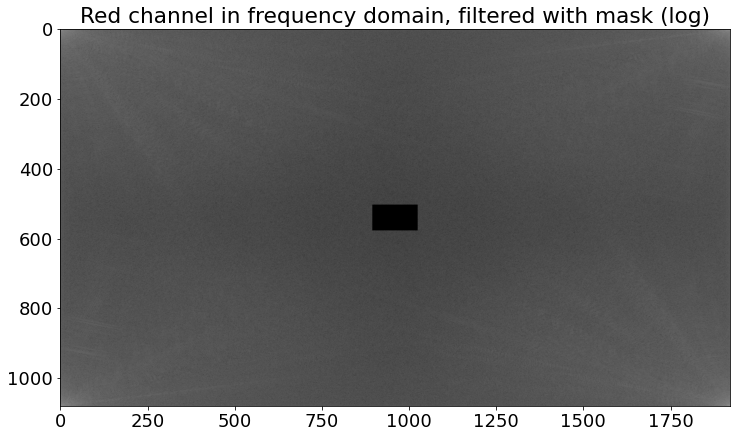

In [7]:
gain = 50000
bin_encoded =  text_to_bits_int(string, gain)
print("bin_encoded:", bin_encoded[:20])

def create_FFTmask(columns, rows, message):
    # calculate minimum part to be cut and add another 3% because of rounding errors and for "safety"
    cut = np.sqrt(2*len(message)/(rows*columns))*1.03

    #cut off high frequencies from R channel
    mask = np.full((rows, columns), True)
    row_start = round(rows/2*(1-cut))
    row_stop = round(rows/2*(1+cut))
    col_start = round(columns/2*(1-cut))
    col_stop = round(columns/2*(1+cut))
    mask[row_start:row_stop, col_start:col_stop] = False  # rectangular

    # x-length of the mask
    x_len_mask = col_stop - col_start 
    # y-length of the mask
    y_len_mask = row_stop - row_start 

    print("cut: ", cut)
    print("message length:", len(message))
    print("confirm:", x_len_mask*y_len_mask/2)

    return mask, cut

cover_r_fft_mask, cut = create_FFTmask(*(image.size), bin_encoded)

cover_r_fft_masked = np.abs(np.fft.fft2(Rot))*cover_r_fft_mask
im = Image.fromarray(20*np.log10(cover_r_fft_masked))
plt.figure()
plt.imshow(im)
plt.title("Red channel in frequency domain, filtered with mask (log)")

C:\Users\maxik\AppData\Local\Temp/ipykernel_38432/2051928647.py:31: RuntimeWarning: divide by zero encountered in log10
  im = Image.fromarray(20*np.log10(fft_abs))


max value before normalization: 258.6695428126476
max value after normalization: 255


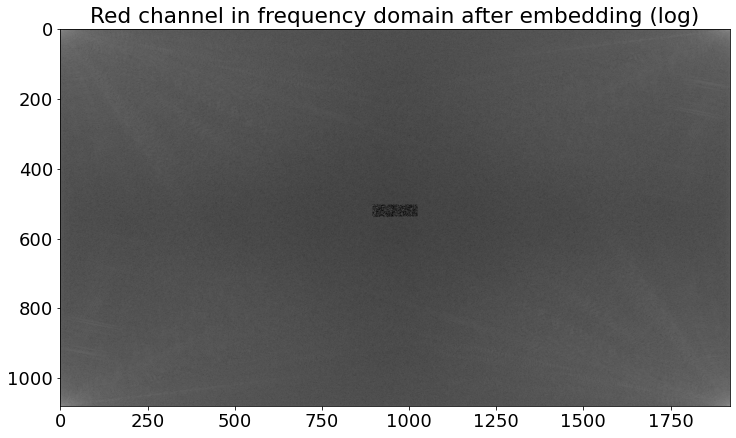

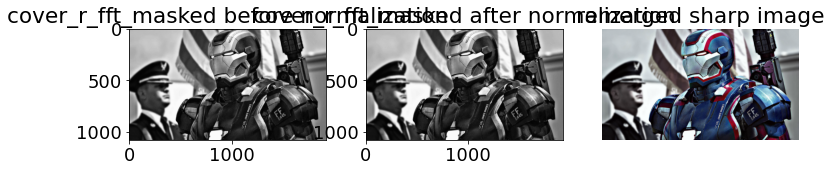

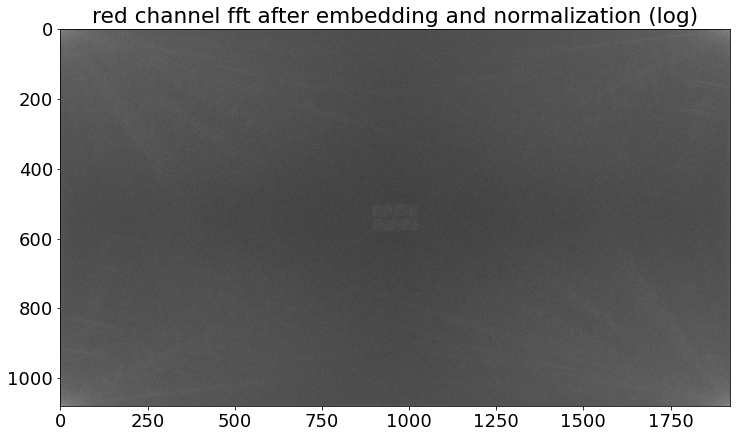

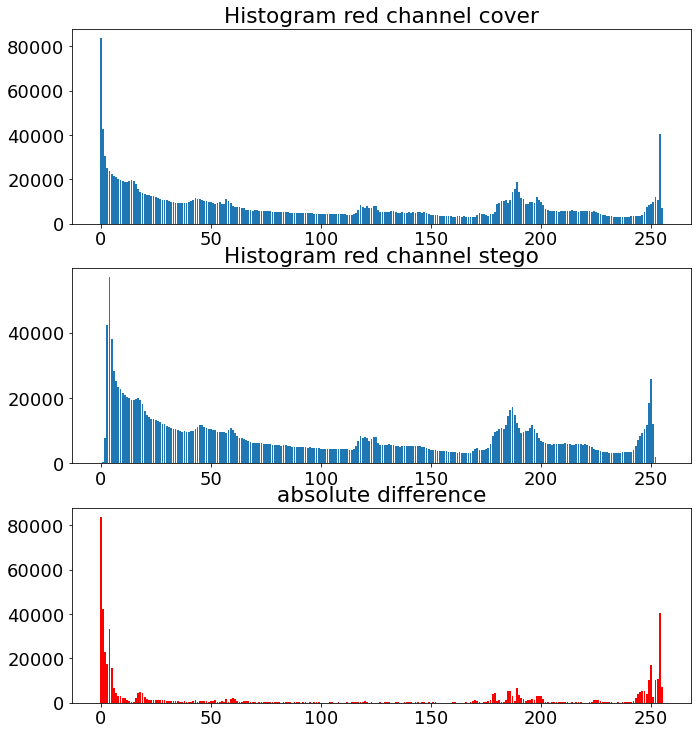

In [8]:
def embedBin2FFT(cover_channel, mask, message):
    fft = np.fft.fft2(cover_channel)
    fft_abs = np.abs(fft)
    ylength, xlength = fft_abs.shape
    
    # write hidden message into filtered absolute part
    counter=0
    for i in range(ylength):
        # if cover_rows == 50:
        #     print("max values", np.max(cover_r_fft_abs[i]))
        for j in range(xlength):
            # write where coefficients are zero -> previously filtered out.
            if mask[i,j]==0:
                if counter<len(message):
                    # write hidden message inside absolute part by overwriting coefficients where the mask is 0
                    fft_abs[i,j]=message[counter]
                    # print(cover_r_fft_abs[i,j])
                    counter+=1

    # # mirror reverse loop
    # counter = 0
    # for i in range(cover_rows-1, -1, -1):
    #     for j in range(cover_cols-1, -1, -1):
    #         if cover_r_fft_mask[i,j]==0:
    #             if counter < len(bin_encoded):
    #                 cover_r_fft_abs[i,j]=bin_encoded[counter]
    #                 counter+=1


    # plot absolute after embedding information
    im = Image.fromarray(20*np.log10(fft_abs))
    plt.figure()
    plt.imshow(im)
    plt.title("Red channel in frequency domain after embedding (log)")

    #IFFT on R channel. Take filtered absolute and inverse with original phase, imaginary part should be negligable
    cover_r_masked = np.fft.ifft2(fft_abs*np.exp(1j*np.angle(fft))).real
    # print(cover_r_masked)
    return cover_r_masked

# get channel with embedded binary data
cover_r_masked = embedBin2FFT(Rot, cover_r_fft_mask, bin_encoded)

# normalize output
cover_r_masked_norm = convert(cover_r_masked, 0,255, np.uint8)

# merge layers
stego =  np.stack((cover_r_masked_norm, Grün, Blau), axis=2).astype('uint8')
# create steganogram
stego_img = Image.fromarray(stego)


# some plots
plt.figure()
plt.subplot(131)
plt.imshow(cover_r_masked, cmap="gray")
plt.title("cover_r_fft_masked before normalization")
plt.subplot(132)
plt.imshow(cover_r_masked_norm, cmap="gray")
plt.title("cover_r_fft_masked after normalization")
plt.subplot(133)
plt.axis('off')
plt.imshow(stego_img) #Show picture with embeddes secret message
plt.title("remerged sharp image")

print("max value before normalization:", np.max(cover_r_masked))
print("max value after normalization:", np.max(cover_r_masked_norm))


sanity_check = Image.fromarray(20*np.log10(np.abs(np.fft.fft2(cover_r_masked_norm))))
plt.figure()
plt.imshow(sanity_check, cmap="gray")
plt.title("red channel fft after embedding and normalization (log)")


# plot histograms
cover_r_hist = Rot.histogram()
stego_r_hist = stego_img.split()[0].histogram()
diff_r_hist = np.abs(np.subtract(np.array(cover_r_hist),np.array(stego_r_hist)))
plt.figure(figsize=(10,10))
plt.subplot(311)
plt.tight_layout()
plt.bar(np.arange(len(cover_r_hist)), cover_r_hist)
plt.title("Histogram red channel cover")
plt.subplot(312)
plt.bar(np.arange(len(stego_r_hist)), stego_r_hist)
plt.title("Histogram red channel stego")
plt.subplot(313)
plt.bar(np.arange(len(diff_r_hist)), diff_r_hist, color="red")
plt.title("absolute difference")

im = stego_img.save("ImageSources\\Steganograms\\remerged_sharp.png")     #save image as png

Calculate mask from cut variable

max value stego_r:
 255


Text(0.5, 1.0, 'calculated fft mask')

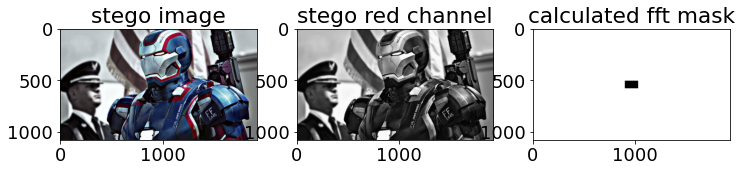

In [10]:
# load and plot image
stego_img = Image.open("ImageSources\\Steganograms\\remerged_sharp.png")

plt.figure()
plt.subplot(131)
plt.imshow(stego_img)
plt.title("stego image")

stego_r, stego_g, stego_b = stego_img.split() #split image into its RGB channels

plt.subplot(132)
plt.imshow(stego_r, cmap="gray")
plt.title("stego red channel")

print("max value stego_r:\n", np.max(stego_r))

# calculate mask
def calculate_FFTmask(columns, rows, cut):
    stego_fft_mask = np.full((rows, columns), True)
    row_start = round(rows/2*(1-cut))
    row_stop = round(rows/2*(1+cut))
    col_start = round(columns/2*(1-cut))
    col_stop = round(columns/2*(1+cut))
    stego_fft_mask[row_start:row_stop, col_start:col_stop] = False  # rectangular

    return stego_fft_mask

stego_fft_mask = calculate_FFTmask(*(stego_img.size), cut)

plt.subplot(133)
plt.imshow(stego_fft_mask, cmap="gray")
plt.title("calculated fft mask")

message length:  4810
[ 1155   641   300 25098   513   510   286 25414  2024 25647 26441 25662
  1218  2338  2056  1931  1094 24619  2937  2979]
threshold 14687.0
binary [0 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0]
parsed message length 4464
bin_decoded:
It's about drive, it's about power
We stay hungry, we devour 💪😄
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana



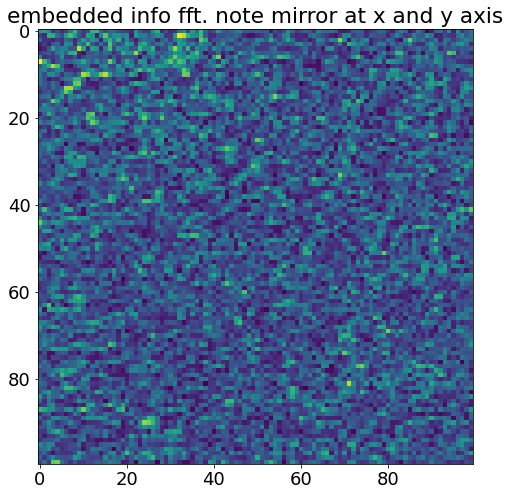

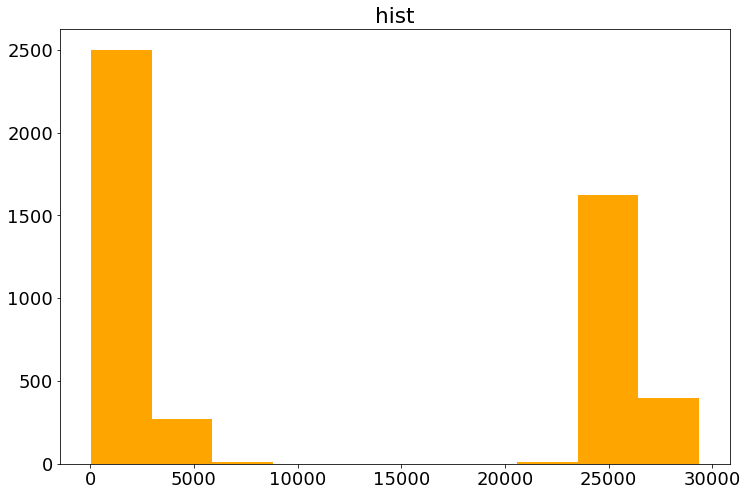

In [11]:
def get_message(stego_channel, mask):
    # transform R channel into frequency domain
    stego_r_fft =np.fft.fft2(stego_channel)
    stego_r_fft_abs = np.abs(stego_r_fft)
    ylen, xlen = stego_r_fft_abs.shape

    plt.figure()
    plt.imshow(stego_r_fft_abs[470:570, 470:570])
    plt.title("embedded info fft. note mirror at x and y axis")
    
    # calculate message length from mask -> predicted message length > true message length!
    message_length = int(np.count_nonzero(mask == False)//2)  #add buffer of 10%
    print("message length: ", message_length)

    # create message buffer
    message=np.zeros(message_length, dtype='uint32')
    counter=0
    for i in range(ylen):
        for j in range(xlen):
            if mask[i,j]==0:
                # loads also data not in the range of the hidden, but gets sliced off later
                if counter==message_length:
                    break
                message[counter] = stego_r_fft_abs[i,j]
                counter+=1 

    return message

message = get_message(stego_r, stego_fft_mask)

print(message[:20])

# plot histogram
plt.figure()
plt.hist(message, histtype="bar", color="orange")
plt.title("hist")

# calculate threshold
threshold = np.max(message)/2
print("threshold", threshold)

# convert message values to binary
binary = message2bin(message, threshold)
print("binary", binary[:20])  # first 2 bytes are length of the embedded message
# convert binary to utf-8
Text, length = text_from_bits_int(binary)
print("parsed message length", length)
print("bin_decoded:")
print(Text)

Now implement a gain finder algorithm

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from FFT_stego import *

plt.rcParams['figure.figsize'] = [10,10]
plt.rcParams.update({'font.size':18})

# cover_img_path = "ImageSources\\jfif\\darth_vader.jfif"
cover_img_path = "ImageSources\\jfif\\the_rock.jfif"
# cover_img_path = "ImageSources\\jfif\\obi-wan_kenobi.jfif"
# PATH = "ImageSources\\png\\r2d2.png"
# cover_img_path = "ImageSources\\jpg\\iron_patriot.jpg"
stego_img_path = "ImageSources\\Steganograms\\remerged_sharp.png"

# input string
string="""It's about drive, it's about power
We stay hungry, we devour 💪😄
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana
"""
def search(cover_img_path, stego_img_path, string ,gain):
    cut = steg_encode(cover_img_path, stego_img_path, string, gain)
    # ---------------------------------------------------------------------------------------------------------------------
    # ---------------------------------------------TRANSMISSION------------------------------------------------------------
    # ---------------------------------------------------------------------------------------------------------------------
    text = steg_decode(stego_img_path, cut)
    
    return text, cut


# find the best gain with recursion
recursive_cnt = 0
success_gain = 0
success_text = ""
def binary_search(low, high):
    global recursive_cnt
    global success_gain
    global success_text
    recursive_cnt += 1
    
    if high >= low:
        gain = low + (high - low)//2

        try:
            Text, _ = search(cover_img_path, stego_img_path, string, gain)    
        except UnicodeDecodeError:
            Text = ""
        print("iteration:", recursive_cnt, "\tgain\t", gain, "\tparsed text:\n", Text[:10])

        if recursive_cnt == 5:
            if Text == string:
                return gain, Text
            else:
                return success_gain, success_text

        if Text == string:
            # save last successful gain and parsed text
            success_text = Text
            success_gain = gain
            # Search the left half
            return binary_search(low, gain-1)
            # Search the right half
        else:
            return binary_search(gain + 1, high)

    else:
        return -1
        

gain = 10000
prev_gain = 0

# reset text
Text = ""
while Text != string:
    try:
        Text, cut = search(cover_img_path, stego_img_path, string, gain)
        if Text != string:
            prev_gain = gain
            Text = ""
            gain *= 2
    # except UnicodeDecodeError as err:
    except ValueError as err:
        prev_gain = gain
        Text = ""
        gain *= 2
    print("gain\t", gain, "\ttext\t", Text)    

gain, Text  = binary_search(prev_gain, gain)
print("gain\t", gain, "\tparsed_text:\n", Text)
print("cut:", cut)

gain	 20000 	text	 
gain	 40000 	text	 
gain	 40000 	text	 It's about drive, it's about power
We stay hungry, we devour 💪😄
Put in the work, put in the hours and take what's ours (ahoo)
Black and Samoan in my veins
My culture bangin' with Strange
I change the game, so what's my motherfuckin' name (Rock)
(What they gonna get though?)
Desecration, defamation, if you wanna bring it to the masses
Face to face, now we escalatin', when I have to put boots to asses
Mean on ya, like a dream when I'm rumblin', you're gonna scream mama
So bring drama to the King Brahma (then what?) 
Comin' at you with extreme mana
It's about drive, it's about power

iteration: 1 	gain	 30000 	parsed text:
 It's about
iteration: 2 	gain	 24999 	parsed text:
 It's about
iteration: 3 	gain	 27499 	parsed text:
 It's about
iteration: 4 	gain	 28749 	parsed text:
 It's about
iteration: 5 	gain	 28124 	parsed text:
 It's about
gain	 28124 	parsed_text:
 It's about drive, it's about power
We stay hungry, we devour 💪😄
Pu

Works with the following image file formats:
*   png
*   bmp
*   tiff
*   webp (not recommended)

DECODER

In [2]:
from PIL import Image
import numpy as np
from FFT_stego import *

parsed_text = steg_decode(stego_img_path, cut)
print(parsed_text)

It's aboet drive, it's about power


In [8]:
start = 10000

target = np.random.randint(0,100000)
print("target", target)
def mysterious_function(value):
    if value < target:
        return False
    else:
        return True


# def search(value):
#     pass
# print(search(start))


recursive_cnt = 0

def binary_search(low, high):
    global recursive_cnt
    recursive_cnt += 1
        
    if high >= low:

        mid = low + (high - low)//2

        if recursive_cnt == 3:
            return mid
        # Search the left half
        if mysterious_function(mid):
            return binary_search(low, mid-1)

        # Search the right half
        else:
            return binary_search(mid + 1, high)

    else:
        return -1


val = start
while not mysterious_function(val):
    prev_val = val
    val *= 2
print(binary_search(prev_val, val))

target 30799
32500
